# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ensemble Learning 

"If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will  
often get better predictions than with the best individual predictor. A group of predictors  
is called an ensemble; thus, this technique is called Ensemble Learning, and an  
Ensemble Learning algorithm is called an Ensemble method."

"As discussed in Chapter 2, you will often use Ensemble methods near the end of a  
project, once you have already built a few good predictors, to combine them into an  
even better predictor."

# Voting Classifier

"A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a hard voting classifier (see Figure 7-2)."

![title](images/voting_classifier_1.png)
![title](images/voting_classifier_2.png)

"Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the  
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning  
it does only slightly better than random guessing), the ensemble can still be a  
strong learner (achieving high accuracy), provided there are a sufficient number of  
weak learners and they are sufficiently diverse."

TIP:"Ensemble methods work best when the predictors are as independent  
from one another as possible. One way to get diverse classifiers  
is to train them using very different algorithms. This increases the  
chance that they will make very different types of errors, improving  
the ensemble’s accuracy."

In [2]:
heads_proba = 0.51
# Note: np.random.rand(10000, 10) return an array of 10 columns and 10,000 rows where each number is x < 1
# np.random.rand(10000, 10) < heads_proba makes a boolean so the array is an array of 1's and 0's
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
print("Coin Tosses: ")
print(coin_tosses)
# Note: np.cumsum(coin_tosses, axis = 0) performs the cumulative sum over the rows
# Np.arrange(1, 10001) creates an array from 1 - 10,000
# .reshape(-1,1) converts the array to a array of 10,000 rows and 1 column
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
print("Cumulative Sum")
print(np.cumsum(coin_tosses, axis=0))
print("Np Arrange")
print(np.arange(1, 10001).reshape(-1,1))
print("Np Arrange with Reshape")
print(np.arange(1, 10001).reshape(-1, 1))
print("Cumulative Head Ratio")
print(cumulative_heads_ratio)

Coin Tosses: 
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 1]
 [0 1 1 ... 0 0 1]
 ...
 [1 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 1]
 [0 1 0 ... 0 1 1]]
Cumulative Sum
[[   1    0    0 ...    0    0    0]
 [   2    0    0 ...    0    1    1]
 [   2    1    1 ...    0    1    2]
 ...
 [5113 5114 5067 ... 5094 5106 5100]
 [5113 5114 5068 ... 5095 5107 5101]
 [5113 5115 5068 ... 5095 5108 5102]]
Np Arrange
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Np Arrange with Reshape
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Cumulative Head Ratio
[[1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.5        0.5       ]
 [0.66666667 0.33333333 0.33333333 ... 0.         0.33333333 0.66666667]
 ...
 [0.51140228 0.5115023  0.50680136 ... 0.5095019  0.51070214 0.51010202]
 [0.51135114 0.51145115 0.50685069 ... 0.50955096 0.51075108 0.51015102]
 [0.5113     0.5115     0.5068     ... 0.5095     0.5108     0.5102    ]]


Saving figure law_of_large_numbers_plot


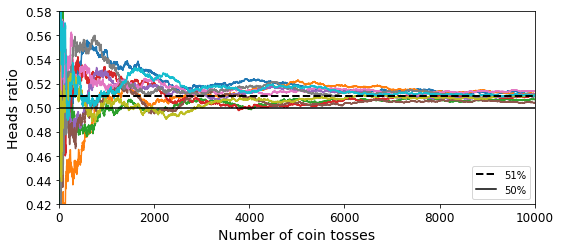

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [6]:
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


"There you have it! The voting classifier slightly outperforms all the individual classifiers."

"If all classifiers are able to estimate class probabilities (i.e., they all have a predict_proba() method),  
then you can tell Scikit-Learn to predict the class with the  
highest class probability, averaged over all the individual classifiers. This is called soft  
voting. It often achieves higher performance than hard voting because it gives more  
weight to highly confident votes. All you need to do is replace voting="hard" with  
voting="soft" and ensure that all classifiers can estimate class probabilities. This is  
not the case for the SVC class by default, so you need to set its probability hyperparameter  
to True (this will make the SVC class use cross-validation to estimate class  
probabilities, slowing down training, and it will add a predict_proba() method). If  
you modify the preceding code to use soft voting, you will find that the voting classifier  
achieves over 91.2% accuracy!"

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability = True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting

"One way to get a diverse set of classifiers is to use very different training algorithms,  
as just discussed. Another approach is to use the same training algorithm for every  
predictor and train them on different random subsets of the training set"

"When sampling is performed with replacement, this method is called bagging (short for bootstrap  
aggregating). When sampling is performed without replacement, it is called pasting"

"In other words, both bagging and pasting allow training instances to be sampled several  
times across multiple predictors, but only bagging allows training instances to be  
sampled several times for the same predictor. This sampling and training process is  
represented in Figure 7-4."

![title](images/bagging_and_pasting_1.png)

"Once all predictors are trained, the ensemble can make a prediction for a new  
instance by simply aggregating the predictions of all predictors. The aggregation  
function is typically the statistical mode (i.e., the most frequent prediction, just like a  
hard voting classifier) for classification, or the average for regression. Each individual  
predictor has a higher bias than if it were trained on the original training set, but  
aggregation reduces both bias and variance.4 Generally, the net result is that the  
ensemble has a similar bias but a lower variance than a single predictor trained on the  
original training set."

## Bagging and Pasting in Scikit-Learn

"Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression)."

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print("Bagging Accuracy: ", accuracy_score(y_test, y_pred))

Bagging Accuracy:  0.904


To performing pasting, set bootstrap = False

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

past_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, random_state=42)
past_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
print("Pasting Accuracy: ", accuracy_score(y_test, y_pred))

Pasting Accuracy:  0.904


In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree Accuracy: ", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy:  0.856


NOTE "The BaggingClassifier automatically performs soft voting  
instead of hard voting if the base classifier can estimate class probabilities  
(i.e., if it has a predict_proba() method), which is the case  
with Decision Tree classifiers."

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


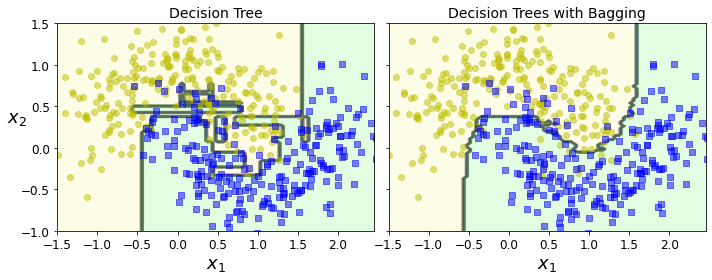

In [15]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

"As you can see, the ensemble’s predictions will likely  
generalize much better than the single Decision Tree’s predictions: the ensemble has a  
comparable bias but a smaller variance (it makes roughly the same number of errors  
on the training set, but the decision boundary is less irregular)."

"Bootstrapping introduces a bit more diversity in the subsets that each predictor is  
trained on, so bagging ends up with a slightly higher bias than pasting; but the extra  
diversity also means that the predictors end up being less correlated, so the ensemble’s  
variance is reduced. Overall, bagging often results in better models, which explains  
why it is generally preferred. However, if you have spare time and CPU power, you  
can use cross-validation to evaluate both bagging and pasting and select the one that  
works best."

## Out-of-Bag Evaluation

"With bagging, some instances may be sampled several times for any given predictor,  
while others may not be sampled at all. By default a BaggingClassifier samples m  
training instances with replacement (bootstrap=True), where m is the size of the  
training set. This means that only about 63% of the training instances are sampled on  
average for each predictor.6 The remaining 37% of the training instances that are not  
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%  
for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on  
these instances, without the need for a separate validation set. You can evaluate the  
ensemble itself by averaging out the oob evaluations of each predictor.  

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to  
request an automatic oob evaluation after training. The following code demonstrates  
this. The resulting evaluation score is available through the oob_score_ variable:" 

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

"According to this oob evaluation, this BaggingClassifier is likely to achieve about  
89.6% accuracy on the test set. Let’s verify this:"

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

Close enough!

"The oob decision function for each training instance is also available through the  
oob_decision_function_ variable. In this case (since the base estimator has a pre   
dict_proba() method), the decision function returns the class probabilities for each   
training instance. For example, the oob evaluation estimates that the first training  
instance has a 68.25% probability of belonging to the positive class (and 31.75% of  
belonging to the negative class):"

In [18]:
# bag_clf.oob_decision_function_

# Random Patches and Random Subspaces

"The BaggingClassifier class supports sampling the features as well. Sampling is  
controlled by two hyperparameters: max_features and bootstrap_features. They  
work the same way as max_samples and bootstrap, but for feature sampling instead  
of instance sampling. Thus, each predictor will be trained on a random subset of the  
input features."

"This technique is particularly useful when you are dealing with high-dimensional  
inputs (such as images). Sampling both training instances and features is called the  
Random Patches method. Keeping all training instances (by setting bootstrap=False  
and max_samples=1.0) but sampling features (by setting bootstrap_features to   
True and/or max_features to a value smaller than 1.0) is called the Random Subspaces  
method."

"Sampling features results in even more predictor diversity, trading a bit more bias for  
a lower variance."

# Random Forests 

"As we have discussed, a Random Forest9 is an ensemble of Decision Trees, generally  
trained via the bagging method (or sometimes pasting), typically with max_samples  
set to the size of the training set. Instead of building a BaggingClassifier and passing  
it a DecisionTreeClassifier, you can instead use the RandomForestClassifier  
class, which is more convenient and optimized for Decision Trees10 (similarly, there is  
a RandomForestRegressor class for regression tasks). The following code uses all  
available CPU cores to train a Random Forest classifier" 

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)


In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

"The Random Forest algorithm introduces extra randomness when growing trees;  
instead of searching for the very best feature when splitting a node (see Chapter 6), it  
searches for the best feature among a random subset of features. The algorithm  
results in greater tree diversity, which (again) trades a higher bias for a lower variance,  
generally yielding an overall better model."

## Extra-Trees
"When you are growing a tree in a Random Forest, at each node only a random subset  
of the features is considered for splitting (as discussed earlier). It is possible to make  
trees even more random by also using random thresholds for each feature rather than  
searching for the best possible thresholds (like regular Decision Trees do)."  

"A forest of such extremely random trees is called an Extremely Randomized Trees  
ensemble (or Extra-Trees for short). Once again, this technique trades more bias for  
a lower variance. It also makes Extra-Trees much faster to train than regular Random  
Forests, because finding the best possible threshold for each feature at every node is  
one of the most time-consuming tasks of growing a tree."

"You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier  
class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra  
TreesRegressor class has the same API as the RandomForestRegressor class."

TIP: "It is hard to tell in advance whether a RandomForestClassifier  
will perform better or worse than an ExtraTreesClassifier. Generally,  
the only way to know is to try both and compare them using  
cross-validation (tuning the hyperparameters using grid search)."

## Feature Importance 

"Yet another great quality of Random Forests is that they make it easy to measure the  
relative importance of each feature. Scikit-Learn measures a feature’s importance by  
looking at how much the tree nodes that use that feature reduce impurity on average  
(across all trees in the forest). More precisely, it is a weighted average, where each  
node’s weight is equal to the number of training samples that are associated with it  
(see Chapter 6)." 

"Scikit-Learn computes this score automatically for each feature after training, then it  
scales the results so that the sum of all importances is equal to 1. You can access the  
result using the feature_importances_ variable. For example, the following code  
trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and  
outputs each feature’s importance. It seems that the most important features are the  
petal length (44%) and width (42%), while sepal length and width are rather unimportant  
in comparison (11% and 2%, respectively):"

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0966148014005634
sepal width (cm) 0.022743706267821087
petal length (cm) 0.4443739304222949
petal width (cm) 0.43626756190932064


"Similarly, if you train a Random Forest classifier on the MNIST dataset (introduced
in Chapter 3) and plot each pixel’s importance, you get the image below."

In [24]:
# from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# mnist.target = mnist.target.astype(np.uint8)

In [25]:
# rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# rnd_clf.fit(mnist["data"], mnist["target"])

In [26]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, 
               cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [27]:
# plot_digit(rnd_clf.feature_importances_)

# cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
# cbar.ax.set_yticklabels(['Not important', 'Very important'])

# save_fig("mnist_feature_importance_plot")
# plt.show()

"Random Forests are very handy to get a quick understanding of what features  
actually matter, in particular if you need to perform feature selection."

# Boosting

"Boosting (originally called hypothesis boosting) refers to any Ensemble method that  
can combine several weak learners into a strong learner. The general idea of most  
boosting methods is to train predictors sequentially, each trying to correct its predecessor."

## AdaBoost

"One way for a new predictor to correct its predecessor is to pay a bit more attention  
to the training instances that the predecessor underfitted. This results in new predictors  
focusing more and more on the hard cases. This is the technique used by AdaBoost."

WARNING: "There is one important drawback to this sequential learning technique:  
it cannot be parallelized (or only partially), since each predictor  
can only be trained after the previous predictor has been  
trained and evaluated. As a result, it does not scale as well as bagging  
or pasting." 

"Scikit-Learn uses a multiclass version of AdaBoost called SAMME16 (which stands for  
Stagewise Additive Modeling using a Multiclass Exponential loss function). When there  
are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate  
class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use  
a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class  
probabilities rather than predictions and generally performs better."

"The following code trains an AdaBoost classifier based on 200 Decision Stumps using  
Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada  
BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in  
other words, a tree composed of a single decision node plus two leaf nodes. This is  
the default base estimator for the AdaBoostClassifier class:"

In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

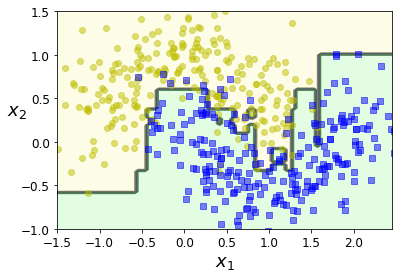

In [29]:
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting

"Another very popular boosting algorithm is Gradient Boosting.17 Just like AdaBoost,  
Gradient Boosting works by sequentially adding predictors to an ensemble, each one  
correcting its predecessor. However, instead of tweaking the instance weights at every  
iteration like AdaBoost does, this method tries to fit the new predictor to the residual  
errors made by the previous predictor."

In [30]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

"First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):"

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

"Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the first predictor:"

In [32]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

"Then we train a third regressor on the residual errors made by the second predictor:"

In [33]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [34]:
X_new = np.array([[0.8]])

"Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:"

In [35]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [36]:
y_pred

array([0.75026781])

"The figure below represents the predictions of these three trees in the left column, and the  
ensemble’s predictions in the right column. In the first row, the ensemble has just one   
tree, so its predictions are exactly the same as the first tree’s predictions. In the second  
row, a new tree is trained on the residual errors of the first tree. On the right you can  
see that the ensemble’s predictions are equal to the sum of the predictions of the first  
two trees. Similarly, in the third row another tree is trained on the residual errors of  
the second tree. You can see that the ensemble’s predictions gradually get better as  
trees are added to the ensemble."   

In [37]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


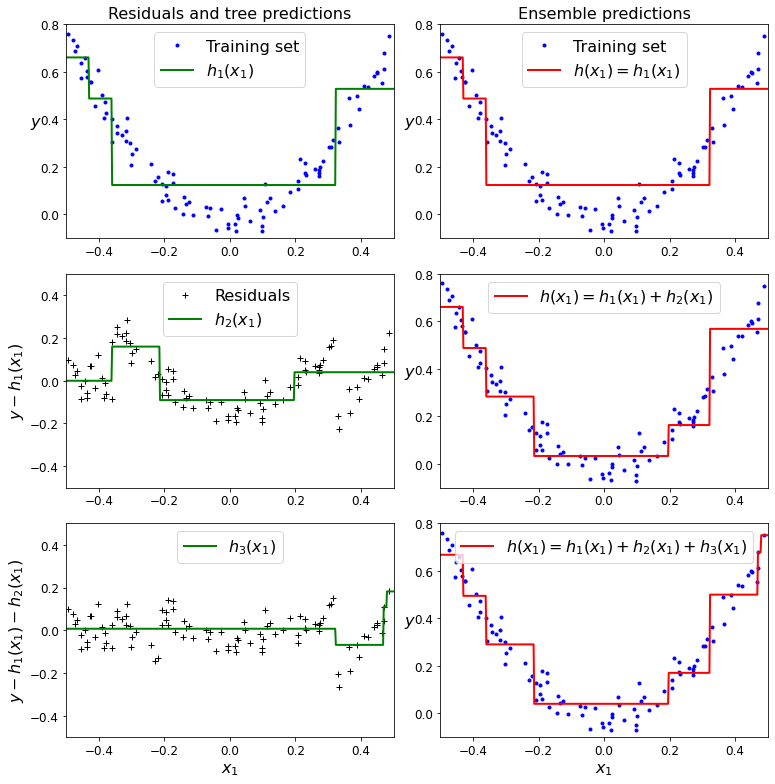

In [38]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

"simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRegressor   
class. Much like the RandomForestRegressor class, it has hyperparameters to    
control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as  
hyperparameters to control the ensemble training, such as the number of trees  
(n_estimators). The following code creates the same ensemble as the previous one:"  

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

## Gradient Boosting with Early stopping

"The learning_rate hyperparameter scales the contribution of each tree. If you set it  
to a low value, such as 0.1, you will need more trees in the ensemble to fit the training  
set, but the predictions will usually generalize better. This is a regularization technique  
called shrinkage."

"In order to find the optimal number of trees, you can use early stopping (see Chapter  
4). A simple way to implement this is to use the staged_predict() method: it  
returns an iterator over the predictions made by the ensemble at each stage of training  
(with one tree, two trees, etc.). The following code trains a GBRT ensemble with  
120 trees, then measures the validation error at each stage of training to find the optimal  
number of trees, and finally trains another GBRT ensemble using the optimal  
number of trees:"

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [42]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


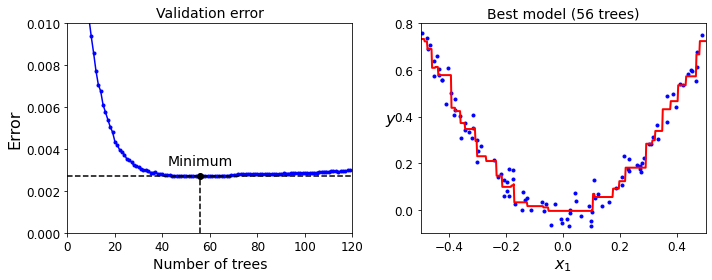

In [43]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

"It is also possible to implement early stopping by actually stopping training early  
(instead of training a large number of trees first and then looking back to find the  
optimal number). You can do so by setting warm_start=True, which makes Scikit-  
Learn keep existing trees when the fit() method is called, allowing incremental  
training. The following code stops training when the validation error does not  
improve for five iterations in a row:"

In [44]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [45]:
print(gbrt.n_estimators)

61


In [46]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


"The GradientBoostingRegressor class also supports a subsample hyperparameter,  
which specifies the fraction of training instances to be used for training each tree. For  
example, if subsample=0.25, then each tree is trained on 25% of the training instances,  
selected randomly. As you can probably guess by now, this technique trades a  
higher bias for a lower variance. It also speeds up training considerably. This is called  
Stochastic Gradient Boosting."

NOTE: "It is possible to use Gradient Boosting with other cost functions.  
This is controlled by the loss hyperparameter (see Scikit-Learn’s  
documentation for more details)."

## XGBoost

"It is worth noting that an optimized implementation of Gradient Boosting is available  
in the popular Python library XGBoost, which stands for Extreme Gradient Boosting.  
This package was initially developed by Tianqi Chen as part of the Distributed (Deep)  
Machine Learning Community (DMLC), and it aims to be extremely fast, scalable,  
and portable. In fact, XGBoost is often an important component of the winning  
entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:"

In [48]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

Error: the xgboost library is not installed.


In [49]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

In [50]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown